**Абдуллаев Тимур ПМ21-1**

<p style="color:black;font-size:220%;text-align:center;"><strong>Построение рекомендательной системы в области закупок с учетом характеристик контракта

# Разделы: <a class="anchor" id="0"></a>

* [1. Введение](#1) 
* [2. Импорт библиотек](#2) 

* [3. Сбор датасета](#3)
    * [3.1. Сбор ИНН участников](#3.1)
    * [3.2. Функции для сбора остальной информации](#3.2)
    * [3.3. Сбор характеристики связей между контрагентами](#3.3)
    * [3.4. Сбор характеристики контрагентов](#3.4)
    * [3.5. Лемматизация](#3.5)
       
* [4. Анализ данных](#4)

* [5. Векторизация](#5)

* [6. Построение графа](#6)

* [7. Анализ графа](#7)

* [8. Разделение на обучающую и тестовую выборки](#8)

* [9. Обучение](#9)
    * [9.1. GraphSAGE](#9.1)
        * [9.1.1. DotPredictor](#9.1.1)
        * [9.1.2. MLPPredictor](#9.1.2)
    * [9.2. GCN](#9.2)
        * [9.2.1. DotPredictor](#9.2)
        * [9.2.2. MLPPredictor](#9.2.2)
* [10. Сравнение результатов](#10)
* [11. Пример получения рекомендаций](#11)
* [12. Заключение](#12)

<a id="1"></a>
# <b><span style='color:blue'>|</span> 1. Введение</b>
* [К оглавлению](#0)

    В современном мире рекомендательные системы используются в различных сферах, включая коммерцию, образование, медицину и государственное управление. В сфере закупок рекомендательные системы могут повысить эффективность выбора контрактных предложений, сократить временные затраты и снизить риски при заключении контрактов.

    Для построения рекомендательной системы важно учитывать конкретные характеристики контрактов, такие как объекты закупок, цены и сроки исполнения. Учитывание характеристик контракта приведут к верным рекомендациям, которые удовлетворяют потребности заказчика и соответствуют специфике отрасли.

    Цель данной курсовой работы заключается в разработке рекомендательной системы, которая учитывает характеристики контрактов и предоставляет заказчикам релевантные рекомендации. Для достижения этой цели будут использоваться методы машинного обучения и графовых баз данных, а также различные техники обработки данных и анализа текста.

    Задачи, которые будут решаться в рамках данной работы, включают в себя сбор и обработку данных о контрактах, построения графа знаний, разработку алгоритмов машинного обучения для построения рекомендаций, а также оценку качества разработанной системы с помощью метрик.

<a id="2"></a>
# <b><span style='color:blue'>|</span> 2. Импорт библиотек</b>
* [К оглавлению](#0)

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from zipfile import ZipFile
import re
import os
import requests
from bs4 import BeautifulSoup
from urllib.parse import urlencode
import dask.bag as db
from dask.diagnostics import ProgressBar

import nltk
from nltk.corpus import stopwords
from collections import Counter
import pymorphy2

import torch
import torch.nn.functional as F
import dgl
import networkx as nx
import scipy.sparse as sp
import torch.nn as nn
import itertools
import dgl.function as fn
from dgl.nn import SAGEConv
from dgl.nn import GraphConv
from dgl.nn import GATConv

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

<a id="3"></a>
# <b><span style='color:blue'>|</span> 3. Сбор датасета</b>
* [К оглавлению](#0)

<a id="3.1"></a>
### <b><span style='color:blue'>|</span> 3.1. Сбор ИНН участников</b>

Имеются архив ZIP и папка, имеющие протоколы разных форматов. Названия файлов содержат ИНН участников закупок (\[ИНН участника]_...), которые являются основой построения рекомендательной системы. Они отбираются с помощью функции TIN.

In [2]:
@np.vectorize
def TIN(filename: str) -> str:
    try: # в случае если попался не файл с закупкой
        new_file_name = re.match(r'[0-9]{9,}', filename).group(0)
        if len(new_file_name) == 9:
            return '0' + new_file_name
        else:
            return new_file_name
    except AttributeError:
        return np.nan

In [3]:
folder = "D:\УЧЕБА\курсовая работа\протоколы_ГосЗакупки_2"
file_names2 = np.array(os.listdir(folder))
with ZipFile(r"D:\УЧЕБА\курсовая работа\протоколы_ГосЗакупки.zip", 'r') as zip:
    file_names1 = np.array(zip.namelist())
file_names = np.concatenate((file_names1, file_names2))

In [4]:
%%time
tins = np.unique(TIN(file_names)).tolist()
tins[:5]

Wall time: 5.02 ms


['0256006322', '0268008010', '0268069694', '0270007455', '0274110679']

<a id="3.2"></a>
### <b><span style='color:blue'>|</span> 3.2. Функции для сбора остальной информации</b>

На сайте zakupki.gov.ru, содержащий историю закупок контрагентов, рассматриваются до 50 (включительно) закупок каждого участника, в каждой из которых отбираются начальная цена закупки, объект закупки и ИНН заказчика.

In [23]:
def find_characteristics(tin):
    list_characts = []
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36'}
    params = {
        'pageNumber': 1,
        'search-filter': 'Дата размещения',
        'fz44': 'on',
        'fz223': 'on',
        'participantName': tin,
        'sortBy': 'UPDATE_DATE',
        'recordsPerPage': '_50',
    }
    base_url = 'https://zakupki.gov.ru/epz/order/extendedsearch/results.html?'
    url = base_url + urlencode(params)
    with requests.get(url, headers=headers) as response:
        response.raise_for_status()
        soup = BeautifulSoup(response.content, 'lxml')
        s_pr = soup.find_all('div', class_='price-block__value')
        s_numb = soup.find_all('div', class_='registry-entry__header-mid__number')
        s_links = soup.find_all('div', class_='registry-entry__body-href')
        for card in range(min(len(s_pr), len(s_numb))):
            if s_pr[card] != [] and s_numb[card] != [] and s_links[card] != []:
                cost = str(''.join(re.findall(r'\d|,', str(s_pr[card].contents[0]))).replace(',', '.'))
                number = str(re.search(r'\d+', s_numb[card].a.contents[0]).group(0))
                link = 'https://zakupki.gov.ru/' + s_links[card].a['href']
                list_characts.append([number, tin, cost, link])
            else:
                list_characts.append([np.nan, np.nan, np.nan, np.nan])
    return list_characts

In [24]:
def find_tin_cust(row):
    try:
        headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36'}
        with requests.get(row[2], headers=headers) as response:
            response.raise_for_status()
            soup1 = BeautifulSoup(response.text, "lxml")
            s1 = soup1.find_all('div', class_ ='registry-entry__body-value')
            row_tin_cust = [row[0], row[1], str(s1[2].contents[0])]
    except:
        row_tin_cust = [np.nan, np.nan, np.nan]
    return row_tin_cust

In [25]:
def find_objects(tin):
    list_objs = []
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36'}
    params = {
        'pageNumber': 1,
        'search-filter': 'Дата размещения',
        'fz44': 'on',
        'fz223': 'on',
        'participantName': tin,
        'sortBy': 'UPDATE_DATE',
        'recordsPerPage': '_20',
    }
    base_url = 'https://zakupki.gov.ru/epz/order/extendedsearch/results.html?'
    url = base_url + urlencode(params)
    with requests.get(url, headers=headers) as response:
        response.raise_for_status()
        soup = BeautifulSoup(response.content, 'lxml')
        s_obj = soup.find_all('div', class_='registry-entry__body-value')
        for card in range(len(s_obj)):
            if s_obj[card] != []:
                object_ = str(s_obj[card].contents[0])
                list_objs.append(object_)
            else:
                list_objs.append(np.nan)
    return [tin, list_objs]

<a id="3.3"></a>
### <b><span style='color:blue'>|</span> 3.3. Сбор характеристики связей между контрагентами</b>

Для ускорения процесса сбора датасета используется dask.bag, который в свою очередь использует мультипроцессинг. Данные конвертируется в датафрейм, содержащий ссылку на ИНН заказчиков. Так как bag **неупорядоченная коллекция**, для получения ИНН заказчика также используются ID и ИНН участника, потому что вместе они уникальны в таблице. Затем данные конкатенируются, исключаются строки, содержащие пустоты. Таблица используется для задания свойств рёбер.
Сбор данных был разделён на две функции в целях ускорения и оптимизации.

In [12]:
with ProgressBar():
    list_characts = db.from_sequence(tins).map(find_characteristics).compute()

[########################################] | 100% Completed | 56.41 s


In [13]:
data_links = pd.DataFrame({'Characteristics': list_characts}).explode('Characteristics').reset_index(drop=True)
new_cols = data_links['Characteristics'].apply(pd.Series)
new_cols.columns = ['ID', 'TIN of Participant', 'Initial Price', 'Link to Customers TIN']
data_links = pd.concat([data_links.drop('Characteristics', axis=1), new_cols], axis=1)
data_links.head()

,ID,TIN of Participant,Initial Price,Link to Customers TIN
0,32211557847,0256006322,9483808.33,https://zakupki.gov.ru//epz/organization/view2...
1,32110296447,0256006322,3240000.00,https://zakupki.gov.ru//epz/organization/view2...
2,32110068299,0256006322,8785370.84,https://zakupki.gov.ru//epz/organization/view2...
3,32009647275,0256006322,137760.00,https://zakupki.gov.ru//epz/organization/view2...
4,32009347076,0256006322,4431008.33,https://zakupki.gov.ru//epz/organization/view2...


In [14]:
data_links.shape

(13566, 4)

In [15]:
data_links.drop_duplicates(subset=['ID', 'TIN of Participant']).shape

(13566, 4)

In [16]:
data_for_cust_tins = data_links[['ID', 'TIN of Participant', 'Link to Customers TIN']]

In [17]:
with ProgressBar():
    cust_tins = db.from_sequence(data_for_cust_tins.values.tolist()).map(find_tin_cust).compute()

[########################################] | 100% Completed | 15m 14s


In [18]:
data_tins = pd.DataFrame({'Info': cust_tins})
new_cols = data_tins['Info'].apply(pd.Series)
new_cols.columns = ['ID', 'TIN of Participant', 'TIN of Customer']
data_tins = pd.concat([data_tins.drop('Info', axis=1), new_cols], axis=1)
data_tins

,ID,TIN of Participant,TIN of Customer
0,32211557847,0256006322,2709001590
1,32110296447,0256006322,2709001590
2,32110068299,0256006322,2709001590
3,32009647275,0256006322,2531002070
4,32009347076,0256006322,2709001590
...,...,...,...
13561,0864500000223000849,nan,6829128395
13562,0864500000223000860,nan,6829128395
13563,0864500000223000859,nan,6829128395
13564,0864500000223000854,nan,6829128395


In [30]:
finish_data = pd.merge(data_links, data_tins, on=['ID', 'TIN of Participant'])
finish_data = finish_data.drop('Link to Customers TIN', axis=1)
finish_data.dropna(inplace=True)
finish_data.head()

,ID,TIN of Participant,Initial Price,TIN of Customer
0,32211557847,0256006322,9483808.33,2709001590
1,32110296447,0256006322,3240000.00,2709001590
2,32110068299,0256006322,8785370.84,2709001590
3,32009647275,0256006322,137760.00,2531002070
4,32009347076,0256006322,4431008.33,2709001590


In [31]:
finish_data.to_csv('data_for_edges.csv', index=False)

<a id="3.4"></a>
### <b><span style='color:blue'>|</span> 3.4. Сбор характеристики контрагентов</b>

На основе полученной таблицы data_for_edges собираются и сортируются все ИНН контрагентов. У каждого рассматриваются до 20 (включительно) объектов в совершенных закупок.

In [36]:
data = pd.read_csv('data_for_edges.csv')
all_tins = pd.concat([data['TIN of Participant'], data['TIN of Customer']]).unique()
all_tins.sort()
all_tins[:5]

array([105018196, 105020004, 202008210, 207006200, 207007690], dtype=int64)

In [63]:
with ProgressBar():
    list_objects = db.from_sequence(all_tins).map(find_objects).compute()

[########################################] | 100% Completed | 571.48 s


In [120]:
data_objs = pd.DataFrame(list_objects, columns=['TIN', 'Purchase Object'])
data_objs

,TIN,Purchase Object
0,105018196,[Услуги по техническому обслуживанию газового ...
1,105020004,[Оказание услуг по повышению квалификации: цик...
2,202008210,[]
3,207006200,[]
4,207007690,[]
...,...,...
3901,9710042298,[Разработка проектов границ территорий и проек...
3902,9715226210,[]
3903,9729030514,[запрос предложений в электронной форме по отб...
3904,9901000235,[Предоставление Ресурсоснабжающей организацией...


<a id="3.5"></a>
### <b><span style='color:blue'>|</span> 3.5. Лемматизация</b>

Объекты каждого контрагента лемматизируются и соединяются в одну строку. Далее отбираются 8 слов в строке, которые встречаются чаще всего. Получаем таблицу, состоящую из ИНН контрагента и ограниченного списка слов из лемматизированных объектов. Таблица используется в качестве задания свтойств вершин будущего графа.

In [79]:
stop_words = set(stopwords.words('russian'))

In [112]:
def lemmatize_text(lst):
    new_lst = []
    for text in lst:
        text = re.sub(r'[^\w\s]', '', text)
        lemmas = []
        for word in text.split():
            if word not in stop_words:
                parsed_word = morph.parse(word)[0]
                lemma = parsed_word.normal_form
                lemmas.append(lemma)
        new_lst.append(' '.join(lemmas))
    return ' '.join(new_lst).split()
morph = pymorphy2.MorphAnalyzer()

In [121]:
%%time
data_objs['Purchase Object'] = data_objs['Purchase Object'].apply(lemmatize_text)

Wall time: 1min 23s


In [123]:
data_objs['Purchase Object'] = data_objs['Purchase Object'].apply(lambda x: ' '.join([word for word, freq in Counter(x).most_common(8)]))
data_objs.head(8)

,TIN,Purchase Object
0,105018196,газовый услуга оборудование технический обслуж...
1,105020004,оказание услуга повышение квалификация среднее...
2,202008210,
3,207006200,
4,207007690,
5,210003329,
6,210003368,
7,210003590,обучение район возраст гражданин дисциплина ос...


In [124]:
data_objs.to_csv('data_for_nodes.csv', index=False)

<a id="4"></a>
# <b><span style='color:blue'>|</span> 4. Анализ данных</b>
* [К оглавлению](#0)

Таблица data_nodes имеет пропуски, которые заполняются пустой строкой.

In [2]:
data_edges = pd.read_csv('data_for_edges.csv')
data_edges.head()

,ID,TIN of Participant,Initial Price,TIN of Customer
0,32211557847,256006322,9483808.33,2709001590
1,32110296447,256006322,3240000.00,2709001590
2,32110068299,256006322,8785370.84,2709001590
3,32009647275,256006322,137760.00,2531002070
4,32009347076,256006322,4431008.33,2709001590


In [3]:
data_edges.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13282 entries, 0 to 13281
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  13282 non-null  int64  
 1   TIN of Participant  13282 non-null  int64  
 2   Initial Price       13282 non-null  float64
 3   TIN of Customer     13282 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 415.2 KB


In [4]:
data_edges.shape

(13282, 4)

In [5]:
data_nodes = pd.read_csv('data_for_nodes.csv')
data_nodes.head(8)

,TIN,Purchase Object
0,105018196,газовый услуга оборудование технический обслуж...
1,105020004,оказание услуга повышение квалификация среднее...
2,202008210,NaN
3,207006200,NaN
4,207007690,NaN
5,210003329,NaN
6,210003368,NaN
7,210003590,обучение район возраст гражданин дисциплина ос...


In [6]:
data_nodes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3906 entries, 0 to 3905
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   TIN              3906 non-null   int64 
 1   Purchase Object  2718 non-null   object
dtypes: int64(1), object(1)
memory usage: 61.2+ KB


In [7]:
data_nodes.shape

(3906, 2)

In [8]:
data_nodes = data_nodes.fillna('')

<a id="5"></a>
# <b><span style='color:blue'>|</span> 5. Векторизация</b>
* [К оглавлению](#0)

Полученные "объекты" векторизируются, так как в качестве свойств графа нельзя использовать данные формата str.\
`TF-IDF (Term Frequency — Inverse Dense Frequency)` -  это метод, который помогает определить важность слов в тексте на основе их частотности.

In [9]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data_nodes['Purchase Object'].tolist())
nodes_features = torch.tensor(X.toarray())
nodes_features

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)

<a id="6"></a>
# <b><span style='color:blue'>|</span> 6. Построение графа</b>
* [К оглавлению](#0)

ИНН контрагентов сортируются и нумеруются от 0 до 3906, чтобы построить граф. Задаются свойства вершин - объекты закупки, свойства рёбер - начальная цена.

In [10]:
def encode_columns(col1, col2):
    sorted_values = sorted(np.unique(data_edges[['TIN of Participant', 'TIN of Customer']].to_numpy()).tolist())
    mapping = {val: i for i, val in enumerate(sorted_values)}
    return pd.DataFrame({'TIN of Participant encoded': [mapping[val] for val in col1],
                         'TIN of Customer encoded': [mapping[val] for val in col2]})

In [11]:
nodes = encode_columns(data_edges['TIN of Participant'], data_edges['TIN of Customer'])
nodes.head()

,TIN of Participant encoded,TIN of Customer encoded
0,39,878
1,39,878
2,39,878
3,39,762
4,39,878


In [12]:
g = dgl.graph((nodes['TIN of Participant encoded'], nodes['TIN of Customer encoded']))

In [13]:
g.ndata['objects'] = nodes_features

In [14]:
g.edata['price'] = torch.tensor(data_edges['Initial Price'])

<a id="7"></a>
# <b><span style='color:blue'>|</span> 7. Анализ графа</b>
* [К оглавлению](#0)

Определим количество вершин и ребер графа

In [111]:
print(f'Граф содержит {g.num_nodes()} вершин и {g.num_edges()} ребер')

Граф содержит 3906 вершин и 13282 ребер


Построим гистограммы распределения количеств входящих и выходящих ребер из каждого узла.

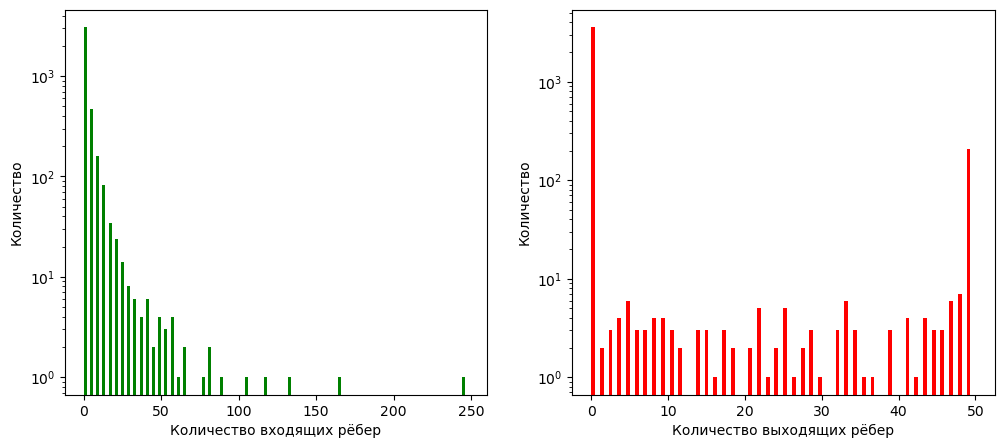

In [104]:
g_in_deg = g.in_degrees().numpy()
g_out_deg = g.out_degrees().numpy()

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].hist(g_in_deg, bins=len(np.unique(g_in_deg)), width=2, color='green')
axs[0].set_xlabel('Количество входящих рёбер')
axs[0].set_ylabel('Количество')
axs[0].set_yscale('log')

axs[1].hist(g_out_deg, bins=len(np.unique(g_out_deg)), width=0.5, color='red')
axs[1].set_xlabel('Количество выходящих рёбер')
axs[1].set_ylabel('Количество')
axs[1].set_yscale('log')

plt.show()

Визуализируем граф с помощью библиотеки NetworkX. 

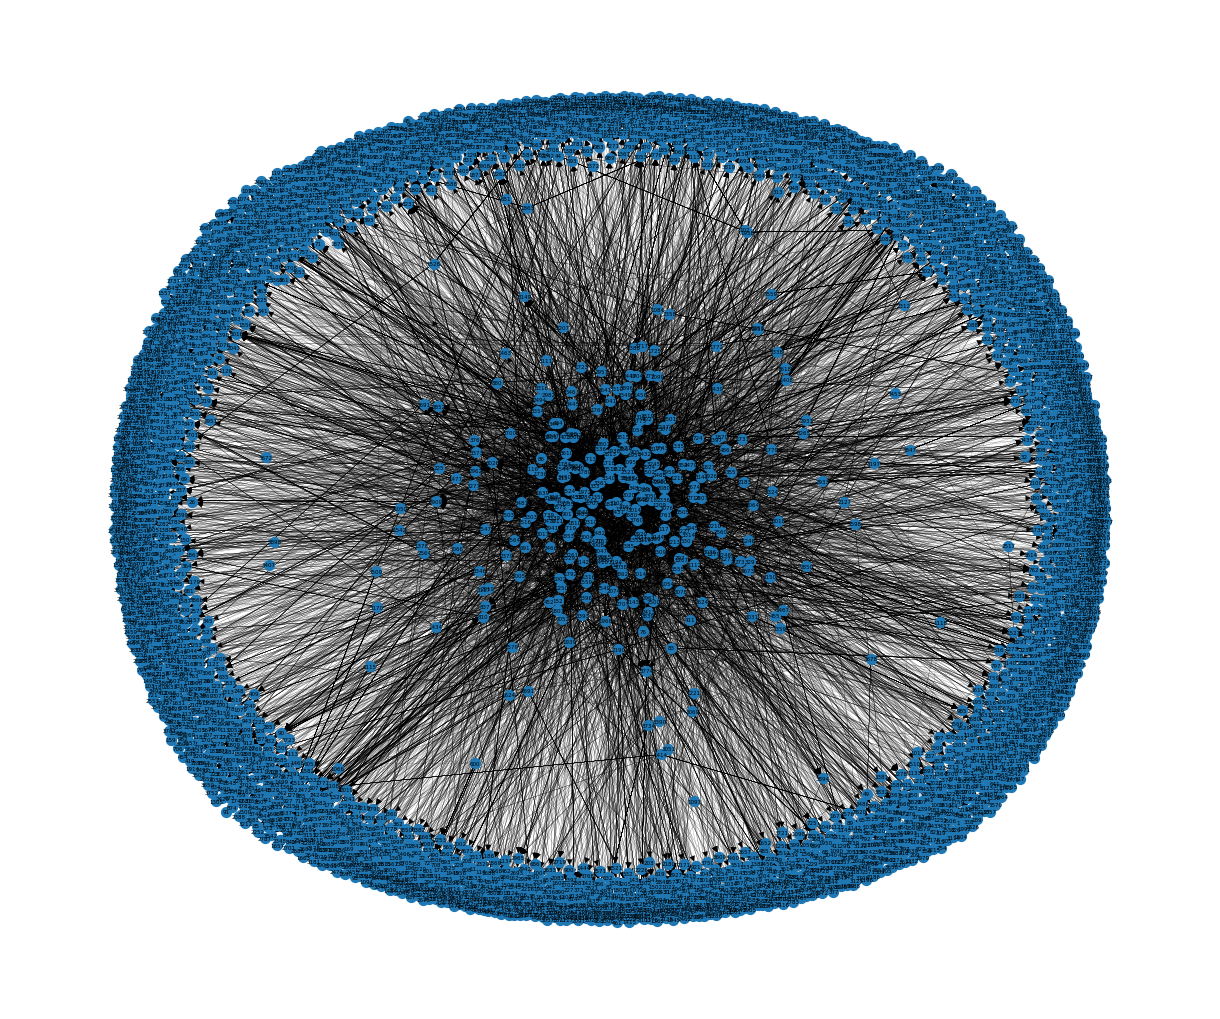

In [44]:
g_nx = dgl.to_networkx(g)
plt.figure(figsize=(12, 10))
nx.draw(g_nx, with_labels=True,font_size=4, node_size=50, width=0.1)
plt.show()

<a id="8"></a>
# <b><span style='color:blue'>|</span> 8. Разделение на обучающую и тестовую выборки</b>
* [К оглавлению](#0)

Граф g раздеялется на тренировочный и тестовый наборы граней.
Сначала определяются все ребра графа g путем получения их исходных и конечных узлов u и v, а затем происходит перетасовка случайного порядка всех ребер. Далее вычисляется количество граней, которые будут использоваться в качестве тестового набора, которое равно 10% от общего количества ребер. Затем создаются тестовый и обучающий наборы граней.
В итоге, тренировочный граф, и соответствующие ему положительные графы готовы для обучения модели, а тестовые графы для оценки качества работы модели.

In [15]:
u, v = g.edges()

eids = np.arange(g.num_edges())
eids = np.random.permutation(eids)
test_size = int(len(eids) * 0.1)
train_size = g.num_edges() - test_size
test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
train_pos_u, train_pos_v = u[eids[test_size:]], v[eids[test_size:]]

adj = sp.coo_matrix((np.ones(len(u)), (u.numpy(), v.numpy())), shape=(3906, 3906))
adj_neg = 1 - adj.todense() - np.eye(g.num_nodes())
neg_u, neg_v = np.where(adj_neg != 0)

neg_eids = np.random.choice(len(neg_u), g.num_edges())
test_neg_u, test_neg_v = (
    neg_u[neg_eids[:test_size]],
    neg_v[neg_eids[:test_size]],
)
train_neg_u, train_neg_v = (
    neg_u[neg_eids[test_size:]],
    neg_v[neg_eids[test_size:]],
)

In [16]:
train_g = dgl.remove_edges(g, eids[:test_size])

In [17]:
train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.num_nodes())
train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.num_nodes())

test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.num_nodes())
test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.num_nodes())

<a id="9"></a>
# <b><span style='color:blue'>|</span> 9. Обучение</b>
* [К оглавлению](#0)

Определены функции потерь и метрик. Функция потерь вычисляет бинарную перекрестную энтропию между прогнозируемыми оценками и истинными метками по формуле:\
$loss = -(y \cdot \ln(sigmoid(x)) + (1 - y) \cdot \ln(1 - sigmoid(x)))$\

Функции метрик, написанные с использованием библиотеки sklearn:
+ `accuracy` (точность) измеряет долю правильных ответов, т. е. отношение числа правильно классифицированных объектов к общему числу объектов в выборке:

+ `Метрика f1` (среднее гармоническое между precision и recall) учитывает несбалансированность классов и представляет собой среднее гармоническое между precision и recall по всем классам, где precision - точность, recall - полнота: $F1 = 2\frac{precision \cdot recall}{precision + recall}$

+ `Метрика AUC-ROC` является мерой качества модели, учитывающей баланс между true positive rate (доля истинно положительных ответов) и false positive rate (доля ложно положительных ответов). AUC-ROC - площадь под кривой ROC, где ROC-кривая - это кривая, которая показывает зависимость TPR от FPR при изменении порога классификации.

Также определена функция инструмента `Confusion matrix` (матрица ошибок). Она представляет собой квадратную матрицу, где каждая строка представляет фактические классы, а каждый столбец представляет прогнозируемые классы, и содержит четыре основных элемента:
- True Positive (TP): Количество объектов, которые модель правильно классифицировала как положительные.
- True Negative (TN): Количество объектов, которые модель правильно классифицировала как отрицательные.
- False Positive (FP): Количество объектов, которые модель неправильно классифицировала как положительные (ложные срабатывания).
- False Negative (FN): Количество объектов, которые модель неправильно классифицировала как отрицательные (ложные пропуски).

In [38]:
def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]
    )
    return F.binary_cross_entropy_with_logits(scores, labels)
def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]
    ).numpy()
    return roc_auc_score(labels, scores)
def compute_f1(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).detach().numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]
    ).detach().numpy()
    pred_labels = np.where(scores > 0.5, 1, 0)
    return f1_score(labels, pred_labels)
def compute_accuracy(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).detach().numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]
    ).detach().numpy()
    pred_labels = np.where(scores > 0.5, 1, 0)
    return accuracy_score(labels, pred_labels)
def compute_conf_matrix(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]
    ).numpy()
    pred_labels = np.where(scores > 0.5, 1, 0)
    return confusion_matrix(labels, pred_labels)

Также создадим таблицу, где будем хранить результаты моделей, чтобы впоследствии сравнить и выбрать лучшую модель.

In [39]:
results = pd.DataFrame(columns=['Name', 'Accuracy', 'F1', 'AUC', 'time (s)'])

<a id="9.1"></a>
## <b><span style='color:blue'>|</span> 9.1. Модель GraphSAGE</b>

Модель `GraphSAGE (Graph Sample and Aggregated)` - это алгоритм, предназначенный для предсказания свойств узлов в графовых данных. Он использует метод агрегации информации из соседних узлов для обновления признаков текущего узла. Основная идея заключается в том, чтобы взять сэмплы из окружающих узлов, объединить их признаки и передать их через несколько слоев нейронной сети для генерации новых признаков текущего узла. Таким образом, каждый узел получает информацию от своих соседей и агрегирует ее для обновления своих признаков.

In [40]:
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, "mean")
        self.conv2 = SAGEConv(h_feats, h_feats, "mean")

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

<a id="9.1.1"></a>
### <b><span style='color:blue'>|</span> 9.1.1. Функция DotPredictor</b>

Функция `DotPredictor` вычисляет новые характеристики рёбер на основе исходных характеристик рёбер и узлов. В частности, вычисляется точечное произведение характеристик инцидентных узлов для каждого ребра

В цикле обучения для каждой эпохи производится прямой проход через модель, вычисляются потери и производится обратное распространение ошибки, после чего обновляются веса модели. Для оценки качества работы модели используются разные метрики (`F1 score, Accuracy, ROC-AUC score, Confusion matrix`).

In [56]:
class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata["h"] = h
            g.apply_edges(fn.u_dot_v("h", "h", "score"))
            return g.edata["score"][:, 0]

In [57]:
model = GraphSAGE(train_g.ndata["objects"].shape[1], 8)
model = model.double()
pred_GD = DotPredictor()

In [58]:
optimizer = torch.optim.Adam(
    itertools.chain(model.parameters(), pred_GD.parameters()), lr=0.01
)

In [59]:
%%time
loss_values = []
f1_values = []
for e in range(170):
    h1 = model(train_g, train_g.ndata["objects"])
    pos_score = pred_GD(train_pos_g, h1)
    neg_score = pred_GD(train_neg_g, h1)
    loss = compute_loss(pos_score, neg_score)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    f1_sc = compute_f1(torch.sigmoid(pos_score), torch.sigmoid(neg_score))
    if e % 5 == 0:
        print("In epoch {}, loss: {}".format(e, round(loss.item(), 5)))
    loss_values.append(loss.item())
    f1_values.append(f1_sc)

In epoch 0, loss: 0.70686
In epoch 5, loss: 0.64961
In epoch 10, loss: 0.573
In epoch 15, loss: 0.51521
In epoch 20, loss: 0.4726
In epoch 25, loss: 0.43697
In epoch 30, loss: 0.40545
In epoch 35, loss: 0.37645
In epoch 40, loss: 0.34966
In epoch 45, loss: 0.32445
In epoch 50, loss: 0.30084
In epoch 55, loss: 0.27875
In epoch 60, loss: 0.25834
In epoch 65, loss: 0.23944
In epoch 70, loss: 0.22153
In epoch 75, loss: 0.20462
In epoch 80, loss: 0.18876
In epoch 85, loss: 0.17398
In epoch 90, loss: 0.16028
In epoch 95, loss: 0.14767
In epoch 100, loss: 0.13608
In epoch 105, loss: 0.12544
In epoch 110, loss: 0.11577
In epoch 115, loss: 0.10713
In epoch 120, loss: 0.0993
In epoch 125, loss: 0.09232
In epoch 130, loss: 0.08602
In epoch 135, loss: 0.08033
In epoch 140, loss: 0.07522
In epoch 145, loss: 0.07057
In epoch 150, loss: 0.06634
In epoch 155, loss: 0.06255
In epoch 160, loss: 0.05911
In epoch 165, loss: 0.056
Wall time: 9.73 s


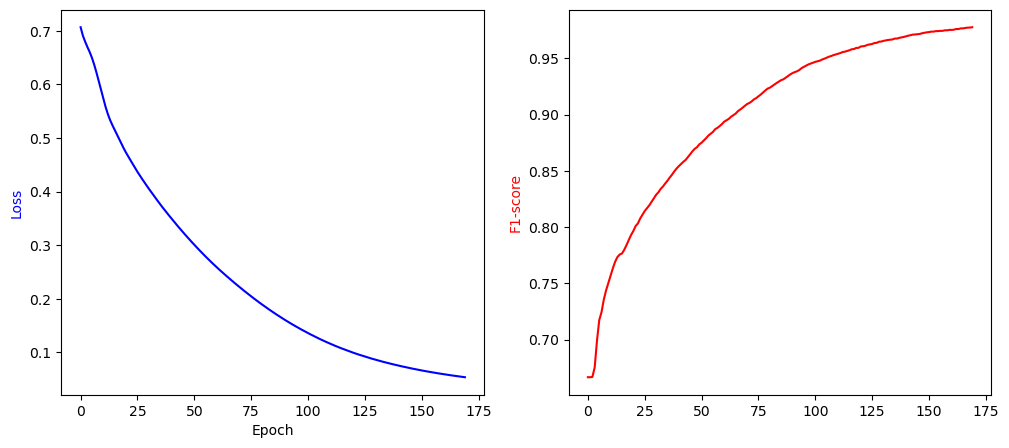

In [60]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(loss_values, 'blue')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss', color='blue')

axs[1].plot(f1_values, 'red')
axs[1].set_ylabel('F1-score', color='red')

plt.show()

In [61]:
with torch.no_grad():
    pos_score_GD = pred_GD(test_pos_g, h1)
    neg_score_GD = pred_GD(test_neg_g, h1)
    pos_prob_GD = torch.sigmoid(pos_score_GD)
    neg_prob_GD = torch.sigmoid(neg_score_GD)
Acc_ = round(compute_accuracy(pos_score_GD, neg_score_GD), 5)
AUC_ = round(compute_auc(pos_score_GD, neg_score_GD), 5)
F1_ = round(compute_f1(pos_prob_GD, neg_prob_GD), 5)
print (f"Accuracy: {Acc_}")
print (f"AUC: {AUC_}")
print (f"F1-score: {F1_}")
results = results.append(pd.Series(['GraphSAGE; DotPredictor', Acc_, F1_, AUC_, '9.73'], index=results.columns), ignore_index=True)

Accuracy: 0.7116
AUC: 0.77987
F1-score: 0.74843


In [62]:
print (f"Confusion matrix: \n{compute_conf_matrix(pos_prob_GD, neg_prob_GD)}")

Confusion matrix: 
[[ 666  662]
 [ 138 1190]]


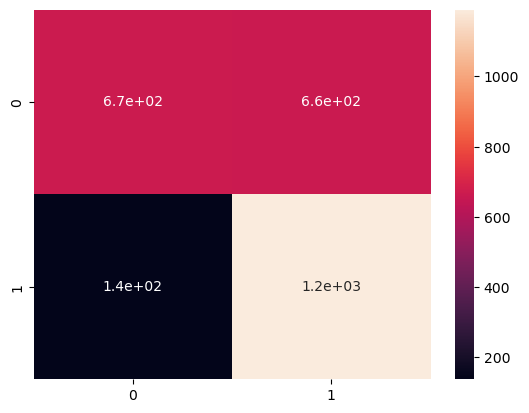

In [63]:
sns.heatmap(compute_conf_matrix(pos_prob_GD, neg_prob_GD), annot=True)
plt.show()

<a id="9.1.2"></a>
### <b><span style='color:blue'>|</span> 9.1.2. Функция MLPPredictor</b>

Функция `MLPPredictor` вычисляет новые характеристики рёбер на основе исходных характеристик рёбер и узлов. В частности, она берет признаки исходных и целевых узлов ребер, объединяет их вместе, пропускает через линейный слой и функцию активации ReLU, а затем применяет второй линейный слой для получения оценок. Результатом является словарь с ключом "score" и соответствующими оценками для каждого ребра.

In [177]:
class MLPPredictor(nn.Module):
    def __init__(self, h_feats):
        super().__init__()
        self.W1 = nn.Linear(h_feats * 2, h_feats)
        self.W2 = nn.Linear(h_feats, 1)

    def apply_edges(self, edges):
        h = (torch.cat([edges.src['h'], edges.dst['h']], 1)).to(torch.float32)
        return {'score': self.W2(F.relu(self.W1(h))).squeeze(1)}

    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(self.apply_edges)
            return g.edata['score']

In [178]:
model = GraphSAGE(train_g.ndata["objects"].shape[1], 8)
model = model.double()
pred_GM = MLPPredictor(8)

In [179]:
optimizer = torch.optim.Adam(
    itertools.chain(model.parameters(), pred_GM.parameters()), lr=0.01
)

In [180]:
%%time
loss_values = []
f1_values = []
for e in range(90):

    h2 = model(train_g, train_g.ndata["objects"])
    pos_score = pred_GM(train_pos_g, h2)
    neg_score = pred_GM(train_neg_g, h2)
    loss = compute_loss(pos_score, neg_score)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    f1_sc = compute_f1(torch.sigmoid(pos_score), torch.sigmoid(neg_score))
    if e % 5 == 0:
        print("In epoch {}, loss: {}".format(e, round(loss.item(), 5)))
    loss_values.append(loss.item())
    f1_values.append(f1_sc)

In epoch 0, loss: 0.70683
In epoch 5, loss: 0.67254
In epoch 10, loss: 0.59203
In epoch 15, loss: 0.43732
In epoch 20, loss: 0.28074
In epoch 25, loss: 0.21841
In epoch 30, loss: 0.1665
In epoch 35, loss: 0.14452
In epoch 40, loss: 0.12463
In epoch 45, loss: 0.11185
In epoch 50, loss: 0.10081
In epoch 55, loss: 0.09155
In epoch 60, loss: 0.08393
In epoch 65, loss: 0.07754
In epoch 70, loss: 0.0721
In epoch 75, loss: 0.06759
In epoch 80, loss: 0.06347
In epoch 85, loss: 0.05956
Wall time: 6.25 s


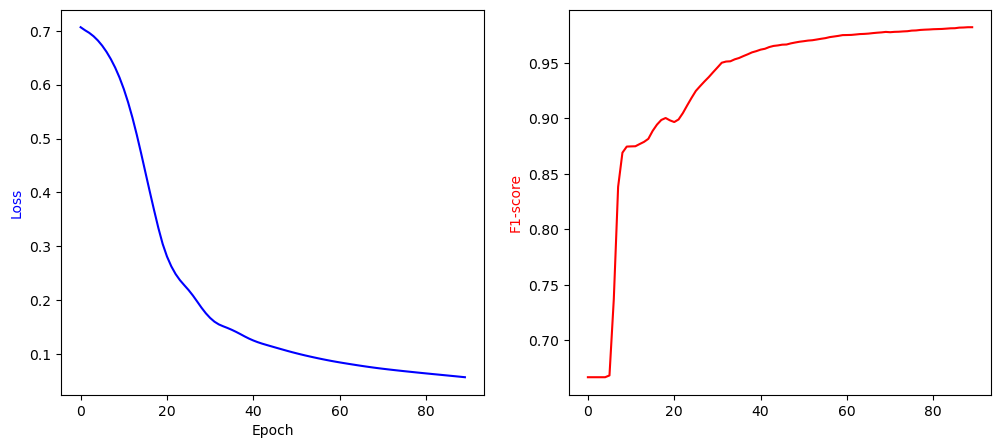

In [181]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(loss_values, 'blue')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss', color='blue')

axs[1].plot(f1_values, 'red')
axs[1].set_ylabel('F1-score', color='red')

plt.show()

In [182]:
with torch.no_grad():
    pos_score_GM = pred_GM(test_pos_g, h2)
    neg_score_GM = pred_GM(test_neg_g, h2)
    pos_prob_GM = torch.sigmoid(pos_score_GM)
    neg_prob_GM = torch.sigmoid(neg_score_GM)
Acc_ = round(compute_accuracy(pos_score_GM, neg_score_GM), 5)
AUC_ = round(compute_auc(pos_score_GM, neg_score_GM), 5)
F1_ = round(compute_f1(pos_prob_GM, neg_prob_GM), 5)
print (f"Accuracy: {Acc_}")
print (f"AUC: {AUC_}")
print (f"F1-score: {F1_}")
results = results.append(pd.Series(['GraphSAGE; MLPPredictor', Acc_, F1_, AUC_, '6.51'], index=results.columns), ignore_index=True)

Accuracy: 0.90964
AUC: 0.96543
F1-score: 0.9154


In [183]:
print (f"Confusion matrix: \n{compute_conf_matrix(pos_prob_GM, neg_prob_GM)}")

Confusion matrix: 
[[1233   95]
 [ 127 1201]]


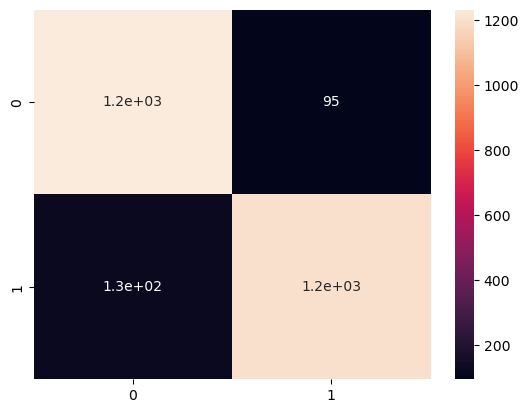

In [184]:
sns.heatmap(compute_conf_matrix(pos_prob_GM, neg_prob_GM), annot=True)
plt.show()

<a id="9.2"></a>
## <b><span style='color:blue'>|</span> 9.2. Модель GCN</b>

Модель `GCN (Graph Convolutional Network)` - это алгоритм, обрабатывающий узлы и ребра графа, а также учитывая структуру соседей каждого узла при выполнении вычислений. GCN выполняет операцию свертки на признаках графа. В каждом слое она учитывает признаки соседних узлов и агрегирует их информацию для обновления признаков текущего узла.

In [81]:
class GCN(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCN, self).__init__()
        self.layer1 = GraphConv(in_feats, out_feats, allow_zero_in_degree=True)
        self.layer2 = GraphConv(out_feats, out_feats, allow_zero_in_degree=True)

    def forward(self, g, features):
        h = self.layer1(g, features)
        h = F.relu(h)
        h = self.layer2(g, h)
        return h

<a id="9.2.1"></a>
### <b><span style='color:blue'>|</span> 9.2.1. Функция DotPredictor</b>

In [82]:
model = GCN(train_g.ndata["objects"].shape[1], 32)
model = model.double()
pred_GCD = DotPredictor()

In [83]:
optimizer = torch.optim.Adam(
    itertools.chain(model.parameters(), pred_GCD.parameters()), lr=0.02
)

In [84]:
%%time
loss_values = []
f1_values = []
for e in range(500):
    h3 = model(train_g, train_g.ndata["objects"])
    pos_score = pred_GCD(train_pos_g, h3)
    neg_score = pred_GCD(train_neg_g, h3)
    loss = compute_loss(pos_score, neg_score)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    f1_sc = compute_f1(torch.sigmoid(pos_score), torch.sigmoid(neg_score))
    if e % 25 == 0:
        print("In epoch {}, loss: {}".format(e, round(loss.item(), 5)))
    loss_values.append(loss.item())
    f1_values.append(f1_sc)

In epoch 0, loss: 0.69315
In epoch 25, loss: 0.6663
In epoch 50, loss: 0.65185
In epoch 75, loss: 0.64094
In epoch 100, loss: 0.63697
In epoch 125, loss: 0.63496
In epoch 150, loss: 0.63379
In epoch 175, loss: 0.63242
In epoch 200, loss: 0.62754
In epoch 225, loss: 0.62251
In epoch 250, loss: 0.62036
In epoch 275, loss: 0.61869
In epoch 300, loss: 0.61667
In epoch 325, loss: 0.61484
In epoch 350, loss: 0.61356
In epoch 375, loss: 0.61192
In epoch 400, loss: 0.60993
In epoch 425, loss: 0.6089
In epoch 450, loss: 0.60902
In epoch 475, loss: 0.60694
Wall time: 44.6 s


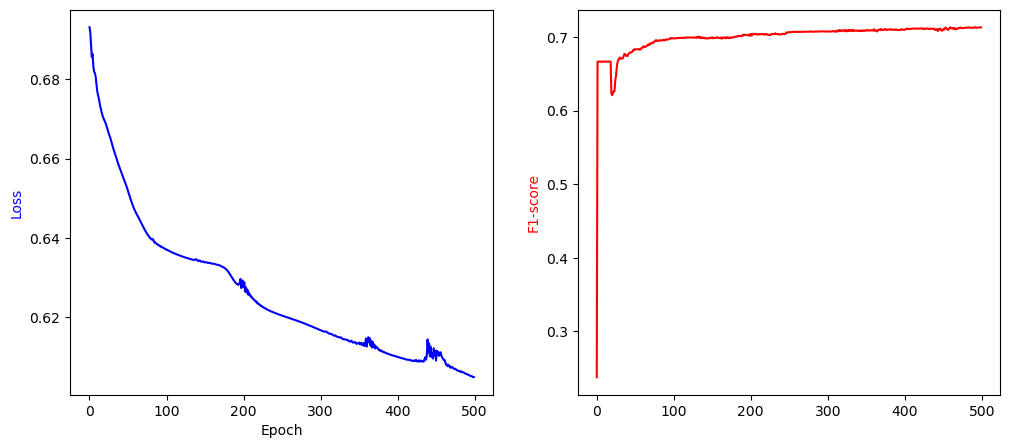

In [85]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(loss_values, 'blue')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss', color='blue')

axs[1].plot(f1_values, 'red')
axs[1].set_ylabel('F1-score', color='red')

plt.show()

In [86]:
with torch.no_grad():
    pos_score_GCD = pred_GCD(test_pos_g, h3)
    neg_score_GCD = pred_GCD(test_neg_g, h3)
    pos_prob_GCD = torch.sigmoid(pos_score_GCD)
    neg_prob_GCD = torch.sigmoid(neg_score_GCD)
Acc_ = round(compute_accuracy(pos_score_GCD, neg_score_GCD), 5)
AUC_ = round(compute_auc(pos_score_GCD, neg_score_GCD), 5)
F1_ = round(compute_f1(pos_prob_GCD, neg_prob_GCD), 5)
print (f"Accuracy: {Acc_}")
print (f"AUC: {AUC_}")
print (f"F1-score: {F1_}")
results = results.append(pd.Series(['GCN; DotPredictor', Acc_, F1_, AUC_, '44.6'], index=results.columns), ignore_index=True)

Accuracy: 0.59789
AUC: 0.64262
F1-score: 0.70551


In [87]:
print (f"Confusion matrix: \n{compute_conf_matrix(pos_prob_GCD, neg_prob_GCD)}")

Confusion matrix: 
[[ 412  916]
 [ 105 1223]]


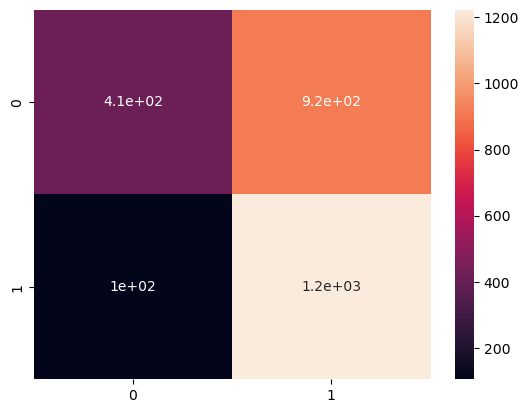

In [88]:
sns.heatmap(compute_conf_matrix(pos_prob_GCD, neg_prob_GCD), annot=True)
plt.show()

<a id="9.2.2"></a>
### <b><span style='color:blue'>|</span> 9.2.2. Функция MLPPredictor</b>

In [102]:
model = GCN(train_g.ndata["objects"].shape[1], 16)
model = model.double()
pred_GCM = MLPPredictor(16)

In [103]:
optimizer = torch.optim.Adam(
    itertools.chain(model.parameters(), pred_GCM.parameters()), lr=0.02
)

In [104]:
%%time
loss_values = []
f1_values = []
for e in range(300):
    
    h4 = model(train_g, train_g.ndata["objects"])
    pos_score = pred_GCM(train_pos_g, h4)
    neg_score = pred_GCM(train_neg_g, h4)
    loss = compute_loss(pos_score, neg_score)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    f1_sc = compute_f1(torch.sigmoid(pos_score), torch.sigmoid(neg_score))
    if e % 10 == 0:
        print("In epoch {}, loss: {}".format(e, round(loss.item(), 5)))
    loss_values.append(loss.item())
    f1_values.append(f1_sc)

In epoch 0, loss: 0.69544
In epoch 10, loss: 0.56126
In epoch 20, loss: 0.44411
In epoch 30, loss: 0.35257
In epoch 40, loss: 0.32693
In epoch 50, loss: 0.30019
In epoch 60, loss: 0.2853
In epoch 70, loss: 0.27257
In epoch 80, loss: 0.25948
In epoch 90, loss: 0.24701
In epoch 100, loss: 0.23629
In epoch 110, loss: 0.22462
In epoch 120, loss: 0.21554
In epoch 130, loss: 0.20965
In epoch 140, loss: 0.20521
In epoch 150, loss: 0.20154
In epoch 160, loss: 0.19874
In epoch 170, loss: 0.19609
In epoch 180, loss: 0.19338
In epoch 190, loss: 0.19121
In epoch 200, loss: 0.18848
In epoch 210, loss: 0.18636
In epoch 220, loss: 0.18402
In epoch 230, loss: 0.18203
In epoch 240, loss: 0.18494
In epoch 250, loss: 0.18134
In epoch 260, loss: 0.17781
In epoch 270, loss: 0.17638
In epoch 280, loss: 0.17529
In epoch 290, loss: 0.17402
Wall time: 28 s


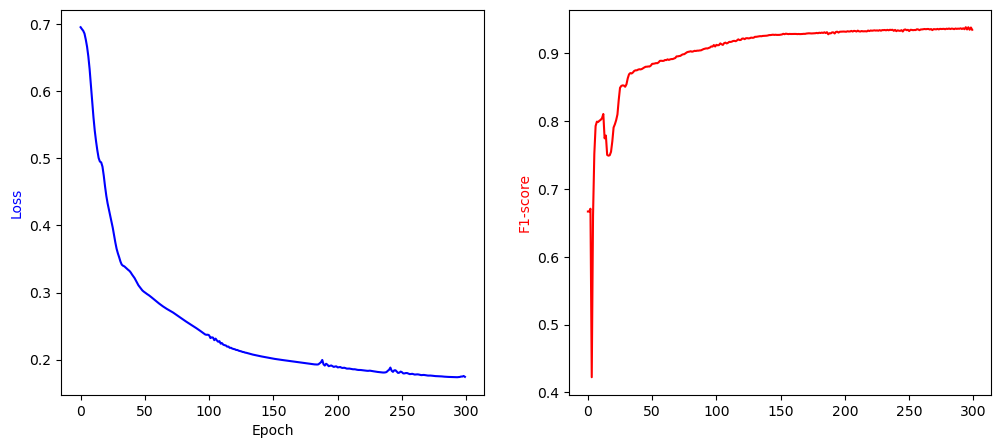

In [105]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# первый график
axs[0].plot(loss_values, 'blue')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss', color='blue')

axs[1].plot(f1_values, 'red')
axs[1].set_ylabel('F1-score', color='red')

# отображаем графики
plt.show()

In [106]:
with torch.no_grad():
    pos_score_GCM = pred_GCM(test_pos_g, h4)
    neg_score_GCM = pred_GCM(test_neg_g, h4)
    pos_prob_GCM = torch.sigmoid(pos_score_GCM)
    neg_prob_GCM = torch.sigmoid(neg_score_GCM)
Acc_ = round(compute_accuracy(pos_score_GCM, neg_score_GCM), 5)
AUC_ = round(compute_auc(pos_score_GCM, neg_score_GCM), 5)
F1_ = round(compute_f1(pos_prob_GCM, neg_prob_GCM), 5)
print (f"Accuracy: {Acc_}")
print (f"AUC: {AUC_}")
print (f"F1-score: {F1_}")
results = results.append(pd.Series(['GCN; MLPPredictor', Acc_, F1_, AUC_, '28'], index=results.columns), ignore_index=True)

Accuracy: 0.84902
AUC: 0.86034
F1-score: 0.84148


In [107]:
print (f"Confusion matrix: \n{compute_conf_matrix(pos_prob_GCM, neg_prob_GCM)}")

Confusion matrix: 
[[1187  141]
 [ 261 1067]]


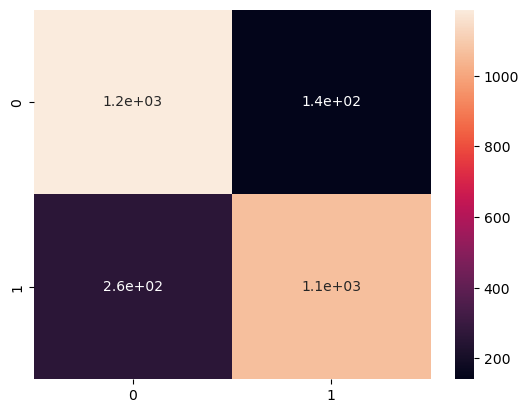

In [108]:
sns.heatmap(compute_conf_matrix(pos_prob_GCM, neg_prob_GCM), annot=True)
plt.show()

<a id="10"></a>
# <b><span style='color:blue'>|</span> 10. Сравнение точности моделей</b>
* [К оглавлению](#0)

In [109]:
results.sort_values('F1', ascending=False)

,Name,Accuracy,F1,AUC,time (s)
1,GraphSAGE; MLPPredictor,0.91566,0.91898,0.96470,6.51
3,GCN; MLPPredictor,0.84902,0.84148,0.86034,28
0,GraphSAGE; DotPredictor,0.71160,0.74843,0.77987,9.73
2,GCN; DotPredictor,0.59789,0.70551,0.64262,44.6


Наилучший результат на тестовой выборке показывает модель GraphSAGE в связке с функцией MLPProdictor. Также алгоритм выполнялся быстрее остальных.

<a id="11"></a>
# <b><span style='color:blue'>|</span> 11. Пример получения рекомендаций </b>
* [К оглавлению](#0)

В качестве примера выведем топ-10 рекомендаций для двух компаний: АО "СБЕРБАНК ЛИЗИНГ" и случайно выбранной. Для построения рекомендаций используем модель, которая показала наилучший результат на тестовой выборке: GraphSAGE в связке с функцией MLPProdictor. 

In [236]:
def tin_to_name(tin):
    if len(str(tin)) == 9:
        tin = '0' + str(tin)
    else:
        tin = str(tin)
    url = f'https://vbankcenter.ru/contragent/search?searchStr={tin}'
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36'}
    with requests.get(url, headers=headers) as response:
        response.raise_for_status()
        soup = BeautifulSoup(response.content, 'lxml')
        s = soup.find('div', class_ = 'p-7 mb-5 rounded border border-night-sky-200')
        name = re.search('>(.*?)<', str(s.a.contents[1])).group(1)
    return name

In [237]:
def recommendation(selected_node):
    # поиск произведенных закупок
    name_selected_company = tin_to_name(data_nodes['TIN'][selected_node])
    print (data_nodes['TIN'][selected_node])
    print(f'Контрагенты, у которых контрагент \033[1m{name_selected_company}\033[0m закупался у:')
    companies_bought = [print(f"* {tin_to_name(data_nodes['TIN'][company.numpy()])}")
     for company in torch.unique(torch.stack(g.in_edges(selected_node), dim=1).view(-1, 2), dim=0).T[0]]
    
    print()
    
    # получение топ-10 рекомендаций для рассматриваемой компании
    g_for_one = dgl.graph(
         (np.concatenate([np.arange(g.nodes().shape[0])[:selected_node], np.arange(g.nodes().shape[0])[selected_node + 1:]]),
          np.full(g.nodes().shape[0] - 1, selected_node)),
         num_nodes=g.num_nodes()
     )
    with torch.no_grad():
        score = pred_GM(g_for_one, h2)
        prob = torch.sigmoid(score)
    companies_prob = torch.cat((g_for_one.edges()[0].unsqueeze(0), prob.unsqueeze(0)), dim=0).numpy()
    ten_sorted_companies = (companies_prob[0, np.argsort(companies_prob[1])[::-1]])[:10]
    print(f'Топ-10 рекомендаций для контрагента \033[1m{name_selected_company}\033[0m:')
    [print(f"* {tin_to_name(data_nodes['TIN'][company.astype(int)])}") for company in ten_sorted_companies]

In [243]:
selected_node = np.random.randint(0, g.nodes().shape[0])
f'Вершина случайно выбранной компании: {selected_node}'

'Вершина случайно выбранной компании: 3494'

In [244]:
recommendation(selected_node)

7736050003
Контрагенты, у которых контрагент ПАО "ГАЗПРОМ" закупался у:
* ПАО "ТАТНЕФТЬ" ИМ. В.Д. ШАШИНА
* ООО "ГАЗПРОМ ГНП ХОЛДИНГ"

Топ-10 рекомендаций для контрагента ПАО "ГАЗПРОМ":
* ООО "НОВАТЭК- ЧЕЛЯБИНСК"
* ПАО "РОССЕТИ ЦЕНТР И ПРИВОЛЖЬЕ"
* АО "ПОЧТА РОССИИ"
* ООО "АТИ"
* ООО "ГАЗПРОМНЕФТЬ МАРИН БУНКЕР"
* ФГУП "РОСМОРПОРТ"
* ПАО "СЕВЕРСТАЛЬ"
* АО "ЭК "ВОСТОК"
* АО "ННК-ПРИМОРНЕФТЕПРОДУКТ"
* ПАО "ГМК "НОРИЛЬСКИЙ НИКЕЛЬ"


In [240]:
recommendation(3099)

7707009586
Контрагенты, у которых контрагент АО "СБЕРБАНК ЛИЗИНГ" закупался у:
* ООО "ЛАНДИС"

Топ-10 рекомендаций для контрагента АО "СБЕРБАНК ЛИЗИНГ":
* ООО "ГАЗПРОМНЕФТЬ МАРИН БУНКЕР"
* ООО "ГНП СЕТЬ"
* ПАО "РОССЕТИ СЕВЕРО-ЗАПАД"
* ООО "МОДЕРН МАШИНЕРИ ФАР ИСТ"
* ООО "КОМУС"
* АО "ЮТЭК-ЭНЕРГИЯ"
* ООО "АТИ"
* ООО "ТД "КОРПОРАЦИЯ ВСМПО-АВИСМА"
* ООО "ГАЗПРОМНЕФТЬ -СМ"
* ООО "ШКАПОВСКОЕ ГПП"


<a id="12"></a>
# <b><span style='color:blue'>|</span> 12. Заключение</b>
* [К оглавлению](#0)

    В данной курсовой работе представлена разработка и построение рекомендательной системы в области закупок с учетом характеристик контракта. Был проведен анализ предметной области, изучены существующие методы и подходы к построению рекомендательных систем, определены характеристики закупок, которые учитывались при построении системы. Был построен граф знаний с помощью библиотеки dgl, обучена с использованием нескольких моделей, проведен анализ построенных моделей с помощью различных метрик и выбрано оптимальное решение.
    
    Опираясь на результаты, можно сказать, что модель GraphSAGE показывает наилучшие результаты, а также является оптимальным по времени. Использование функции MLPPredictor для получения для каждого ребра оценок, предсказывающих, есть ли связь между узлами, исходя из результат метрик является оптимальным.
    
    Таким образом, можно заключить, что данная работа имеет практическую значимость для получения рекомендаций контрагентов на основе характеристик закупок. Дальнейшее развитие исследования может быть связано с применением других, более сложных, моделей, использованием иных характеристик закупок, увеличением объема данных.